In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Every operation needs to be propogated backwards with its derivative
# Value class needs the value that holds a float
# - needs to overload the ops
# - needs to be able to get the grad of the final output wrt the current value

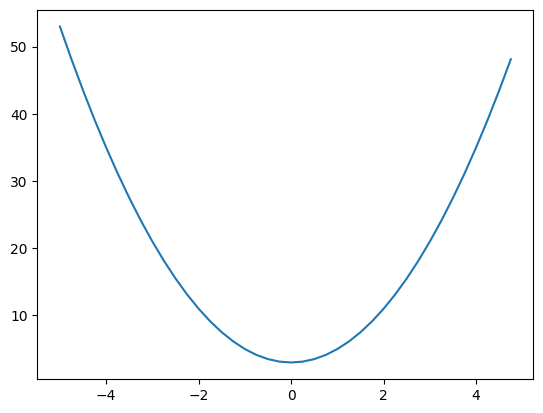

In [3]:
def f(x):
    return 2 * (x ** 2) + 3

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [79]:
class Value:
    def __init__(self, data, _children = (), _op = "", label = "_no_label_", op_der = lambda: None):
        # Only two children for now and one operation
        self.data = data
        self.op_der = op_der
        self.grad = 0.0
        self.children = set(_children)
        self.op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data = {self.data}, _children = {self.children}, _op = {self.op})"

    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
            
        out = Value(self.data + other.data, (self, other), "+")
        def _der():
            self.grad += out.grad
            other.grad += out.grad
        out.op_der = _der
        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + -(other)

    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
            
        out = Value(self.data * other.data, (self, other), "*")
        def _der():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
        out.op_der = _der
        return out

    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only int/float allowed"

        out = Value(self.data ** other, (self, ), f'**{other}')
        def _der():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out.op_der = _der
        return out

    def __truediv__(self, other):
        return self * (other ** -1)
        
    def __rtruediv__(self, other):
        return other * (self ** -1)
    
    def tanh(self):
        x = self.data
        val = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(val, (self, ), "tanh")
        def _der():
            self.grad += (1 - val**2) * out.grad
        out.op_der = _der
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self, ), "relu")

        def _der():
            self.grad += (out.data > 0) * out.grad
        out.op_der = _der
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _der():
            self.grad += out.data * out.grad
        out.op_der = _der
        return out

    def old_trace(self, depth=1):
        print(f"{self.label}={self.data}", f"grad={self.grad}", self.op)
        
        for child in self.children:
            print(end="  "*depth)
            child.trace(depth+1)
    
    def trace(self, depth=1):
        if self.label != "_no_label_":
            print(f"{self.label}={self.data}", f"grad={self.grad}", self.op)
        
        for child in self.children:
            if self.label != "_no_label_":
                print(end="  "*depth)
                child.trace(depth+1)
            else:
                child.trace(depth)

    def backward(self):
        # Calculate the gradients wrt each children and recurse till no children
        # Each child node's grad will be with respect to self
        # To get each child node's global grad, we need to multiply with current grad

        # Calculate toposort of DAG and call backward for all the child nodes in that order
        topo = []
        visited = set()
        def build_topo(node):
            if node in visited:
                return

            visited.add(node)
            for child in node.children:
                build_topo(child)
            topo.append(node)
        
        build_topo(self)

        # Set current node grad as 1
        self.grad = 1.0

        for node in reversed(topo):
            node.op_der()

In [85]:
# micrograd readme example

a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3; 
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
a.label = "a"
b.label = "b"
c.label = "c"
d.label = "d"
e.label = "e"
f.label = "f"
g.label = "g"
print(f'{g.data:.4f}') # prints 24.7041, the outcome of this forward pass
g.backward()
print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db

24.7041
138.8338
645.5773


In [73]:
# neuron example 

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.88137358, label="b")
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

In [74]:
o.trace()

o=0.707106777676776 grad=0.0 tanh
  n=0.88137358 grad=0.0 +
    b=6.88137358 grad=0.0 
    x1w1+x2w2=-6.0 grad=0.0 +
      x2w2=0.0 grad=0.0 *
        w2=1.0 grad=0.0 
        x2=0.0 grad=0.0 
      x1w1=-6.0 grad=0.0 *
        x1=2.0 grad=0.0 
        w1=-3.0 grad=0.0 


In [75]:
o.backward()
o.trace()

o=0.707106777676776 grad=1.0 tanh
  n=0.88137358 grad=0.5000000049635664 +
    b=6.88137358 grad=0.5000000049635664 
    x1w1+x2w2=-6.0 grad=0.5000000049635664 +
      x2w2=0.0 grad=0.5000000049635664 *
        w2=1.0 grad=0.0 
        x2=0.0 grad=0.5000000049635664 
      x1w1=-6.0 grad=0.5000000049635664 *
        x1=2.0 grad=-1.5000000148906993 
        w1=-3.0 grad=1.000000009927133 


In [76]:
# neuron example with broken down tanh

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.88137358, label="b")
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2 + b; n.label = "n"

e = (2*n).exp(); e.label = "e"
o = (e - 1) / (e + 1)

o.label = "o"

In [77]:
o.trace()

o=0.7071067776767761 grad=0.0 *
  e=5.828427042920401 grad=0.0 exp
    n=0.88137358 grad=0.0 +
      b=6.88137358 grad=0.0 
      x1w1+x2w2=-6.0 grad=0.0 +
        x1w1=-6.0 grad=0.0 *
          x1=2.0 grad=0.0 
          w1=-3.0 grad=0.0 
        x2w2=0.0 grad=0.0 *
          w2=1.0 grad=0.0 
          x2=0.0 grad=0.0 
  e=5.828427042920401 grad=0.0 exp
    n=0.88137358 grad=0.0 +
      b=6.88137358 grad=0.0 
      x1w1+x2w2=-6.0 grad=0.0 +
        x1w1=-6.0 grad=0.0 *
          x1=2.0 grad=0.0 
          w1=-3.0 grad=0.0 
        x2w2=0.0 grad=0.0 *
          w2=1.0 grad=0.0 
          x2=0.0 grad=0.0 


In [78]:
o.backward()
o.trace()

o=0.7071067776767761 grad=1.0 *
  e=5.828427042920401 grad=0.04289321984144076 exp
    n=0.88137358 grad=0.5000000049635664 +
      b=6.88137358 grad=0.5000000049635664 
      x1w1+x2w2=-6.0 grad=0.5000000049635664 +
        x1w1=-6.0 grad=0.5000000049635664 *
          x1=2.0 grad=-1.5000000148906993 
          w1=-3.0 grad=1.000000009927133 
        x2w2=0.0 grad=0.5000000049635664 *
          w2=1.0 grad=0.0 
          x2=0.0 grad=0.5000000049635664 
  e=5.828427042920401 grad=0.04289321984144076 exp
    n=0.88137358 grad=0.5000000049635664 +
      b=6.88137358 grad=0.5000000049635664 
      x1w1+x2w2=-6.0 grad=0.5000000049635664 +
        x1w1=-6.0 grad=0.5000000049635664 *
          x1=2.0 grad=-1.5000000148906993 
          w1=-3.0 grad=1.000000009927133 
        x2w2=0.0 grad=0.5000000049635664 *
          w2=1.0 grad=0.0 
          x2=0.0 grad=0.5000000049635664 
